In [1]:
import gymnasium as gym
import my_package
import torch
import numpy as np
import matplotlib.pyplot as plt

from my_package.core.AC import A2C_agent

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data = torch.load('ShipUniCont-v0_500_ep_1_actions.pth')
state_dim = data['state_dim']
action_dim = data['action_dim']
actor_lr = data['actor_lr']
critic_lr = data['critic_lr']
tau = data['tau'] 
hidden_layer_dim = data['hidden_layer_dim']
training_ep = data['max_episodes']
env_name = data['env_name']
Options = data['Options']

""" Init AC agent """
agent = A2C_agent(
    state_dim=state_dim, 
    action_dim=action_dim, 
    hidden_dim=hidden_layer_dim,
    actor_lr=actor_lr,
    critic_lr=critic_lr,
    tau=tau,
    device=device
)

agent.actor.load_state_dict(data['actor_state_dict'])
agent.critic.load_state_dict(data['critic_state_dict'])

print(f'Loaded training results with following options:')
Options

/tmp/ipykernel_30683/947010894.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('ShipUniCont-v0_500_ep_1_actions.pth')


Loaded training results with following options:


{'generate_random_ship': True,
 'ship_perimeter': 12,
 'workspace_safe_distance': 2,
 'segments_lenght': 0.25,
 'frame_per_step': 10,
 'init_pose': None,
 'agent_radius': 0.1,
 'v_surge_max': 0.05,
 'n_actions': 1,
 'frontal_safe_distance': 0.5,
 'lidar_params': {'n_beams': 10, 'max_range': 2.0, 'FoV': 1.5707963267948966},
 'draw_lidar': True,
 'max_steps': 2000}

In [3]:
env = gym.make(env_name, Options=Options, render_mode='human')
for ep in range(5):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.select_action(state, 0.0)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
        
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)env.close()
env.close()

total reward: 26.750000000000014
total reward: -44.99999999999999
total reward: 29.515000000000015
total reward: 30.340000000000003
total reward: 28.280000000000033


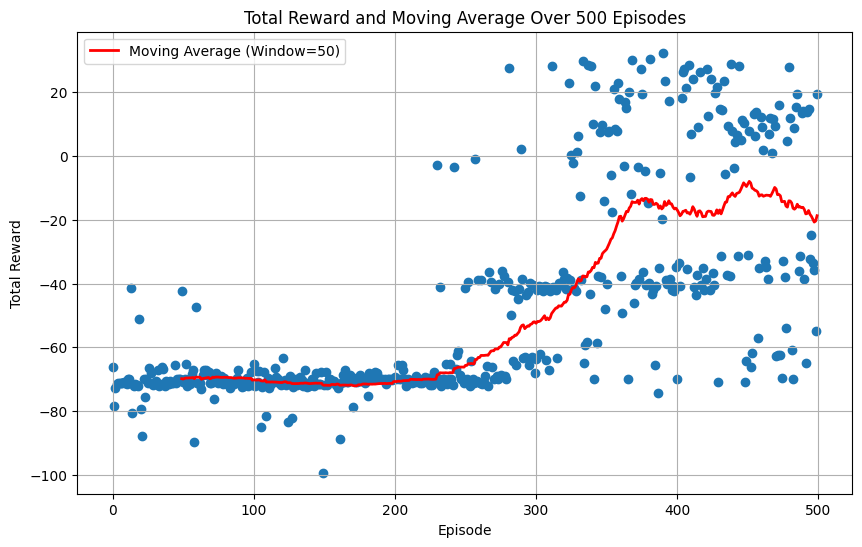

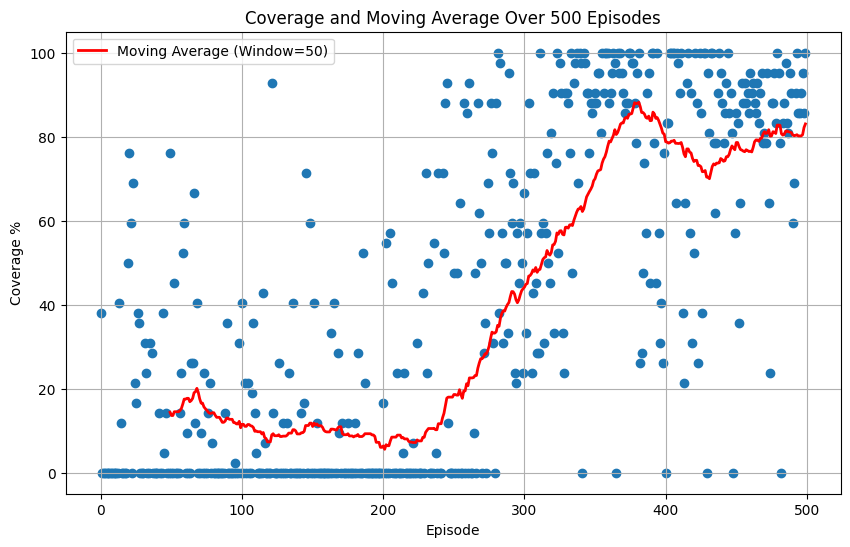

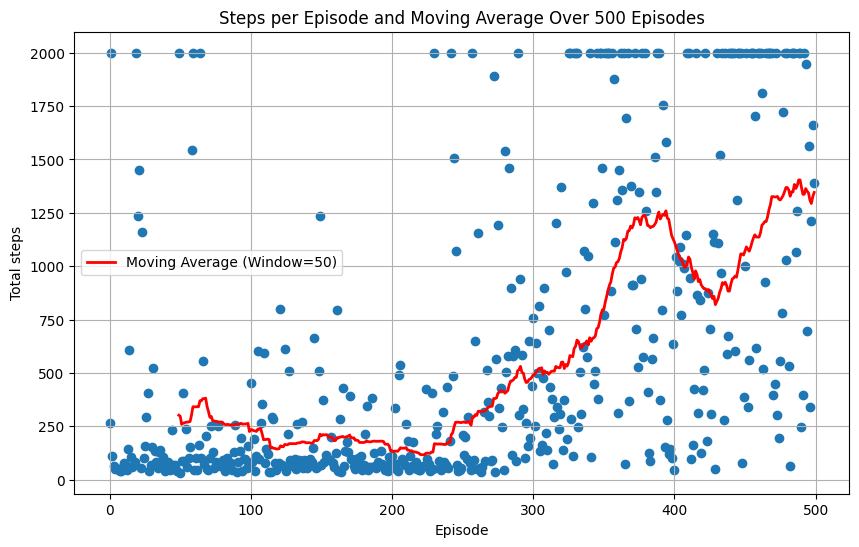

In [7]:
total_rewards = data['total_rewards']
coverage_per_ep = data['coverage_per_ep']
len_episodes = data['len_episodes']

""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title(f'Total Reward and Moving Average Over {training_ep} Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

""" Plot coverage """
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title(f'Coverage and Moving Average Over {training_ep} Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
# plt.savefig('coverage.jpeg')

plt.show()
""" Plot episode duration """
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, len(len_episodes)), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title(f'Steps per Episode and Moving Average Over {training_ep} Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

""" Plot alpha decay """
if 'alpha_decay' in data.keys():
    lr_per_ep = data['lr_per_ep']
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(lr_per_ep)), lr_per_ep, label='LR Decay')
    plt.title('LR Decay per Episode')
    plt.xlabel('Episode')
    plt.ylabel('LR')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Options['ship_perimeter'] = 8
import imageio 

images = []
Options['draw_lidar'] = True

env = gym.make(env_name, Options=Options, render_mode='rgb_array')
state, info = env.reset()
img = env.render()
done = False
total_reward = 0
while not done:
    images.append(img)
    action = select_action(state, policy_net, 0, action_dim)
    next_state, reward, terminated, truncated, info = env.step(action)
    img = env.render()
    done = terminated or truncated
    state = next_state
    total_reward += reward
images.append(img)
print('total reward: ' + str(total_reward))
env.close()
# if total_reward > 8:
# imageio.mimsave("ShipQuest_failed.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=20)
# imageio.imsave("Agent.jpeg", img)